## Module 4: Lens Modeling & Subhalo Detection

### Purpose
Attempt to recover the injected subhalos from the simulated observations using lens modeling techniques, quantifying detection significance.

BUT, this doesn't have to be with Bayesian evidence, because it isn't an absolute study. It can be chi-square?

In [60]:
# ========================================
# Cell 1: Imports and Environment Setup
# ========================================

import yaml
import autolens as al
import autolens.plot as aplt
import autofit as af
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import json
from scipy.stats import chi2
from scipy import ndimage
from typing import Dict, Tuple, List, Optional
from dataclasses import dataclass
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

# Add hwoslaps to path to import our modules
sys.path.insert(0, str(Path.cwd()))
from hwoslaps.lensing import generate_lensing_system
from hwoslaps.psf import generate_psf_system
from hwoslaps.observation import generate_observation
from hwoslaps.lensing.utils import LensingData
from hwoslaps.psf.utils import PSFData
from hwoslaps.observation.utils import ObservationData

# Path configuration
windows_path = '/home/wslgeorgios'
mac_path = '/Users/vassilak/research/hwo'

# Set path based on system
use_mac_path = True
if use_mac_path:
    base_path = mac_path
else:
    base_path = windows_path

# Use the exact paths you provided
config_path = f'{base_path}/hwo-slaps/configs/master_config.yaml'
output_path_prefix = f'{base_path}/outputs/proto_module4'

# Print the paths to verify
print(f"Config Path: {config_path}")
print(f"Output Path Prefix: {output_path_prefix}")
print(f"Current Working Directory: {Path.cwd()}")

# Set up plotting
plt.style.use('default')
# %matplotlib inline  # Uncomment in Jupyter

# Create output directory if it doesn't exist
Path(output_path_prefix).mkdir(parents=True, exist_ok=True)
print(f"Output directory ready: {output_path_prefix}")

Config Path: /Users/vassilak/research/hwo/hwo-slaps/configs/master_config.yaml
Output Path Prefix: /Users/vassilak/research/hwo/outputs/proto_module4
Current Working Directory: /Users/vassilak/research/hwo/hwo-slaps/notebooks
Output directory ready: /Users/vassilak/research/hwo/outputs/proto_module4


In [61]:
# ========================================
# Cell 2: Load Configuration and Generate Test Data
# ========================================

# Load configuration
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
    
print("Configuration loaded successfully")
print(f"Run name: {config['run_name']}")

# Create a version without subhalo for baseline
config_no_subhalo = deepcopy(config)
config_no_subhalo['lensing']['subhalo']['enabled'] = False  # No subhalo

# Generate test data using the pipeline
print("\nGenerating baseline lensing system (no subhalo)...")
lensing_data = generate_lensing_system(config_no_subhalo['lensing'], full_config=config_no_subhalo)

print("\nGenerating PSF system...")
psf_data = generate_psf_system(config['psf'], full_config=config)

print("\nGenerating baseline observation (no subhalo)...")
observation_data = generate_observation(
    lensing_data=lensing_data,
    psf_data=psf_data,
    observation_config=config.get('observation', None),
    full_config=config
)

print("\nData generation complete!")
print(f"Image shape: {observation_data.data.shape}")
print(f"Noise map shape: {observation_data.noise_map.shape}")
print(f"PSF shape: {observation_data.psf.shape}")

Configuration loaded successfully
Run name: nfw_subhalo

Generating baseline lensing system (no subhalo)...

Generating PSF system...
Auto-adjusting PSF sampling: requested=5, used=5.9803 to achieve integer subsampling of N=3.

Generating baseline observation (no subhalo)...

Data generation complete!
Image shape: (250000,)
Noise map shape: (250000,)
PSF shape: (20449,)


In [62]:
# ========================================
# Cell 3: Chi-Square Detection Implementation
# ========================================

# Note: PyAutoLens uses Array2D objects, but we convert to numpy arrays
# for chi-square calculations to ensure compatibility with scipy.stats

@dataclass
class DetectionResult:
    """Store results from subhalo detection."""
    chi2_value: float
    threshold: float
    detected: bool
    significance_level: float
    dof: int
    position: Tuple[float, float]
    snr_mask: np.ndarray
    residual: np.ndarray
    num_regions: int
    max_region_snr: float

class ChiSquareSubhaloDetector:
    """
    Subhalo detection using chi-square statistics.
    
    Based on mejiro's approach but adapted for HWO-SLAPS pipeline.
    Uses regional SNR calculation and Pearson's chi-squared test.
    """
    
    def __init__(self, 
                 observation_data_no_subhalo: ObservationData,
                 source_counts_ground_truth: np.ndarray,
                 snr_threshold: float = 1.0,
                 significance_levels: List[float] = [0.001, 0.0001, 0.00001],
                 use_full_variance: bool = True):
        """
        Initialize the detector.
        
        Parameters
        ----------
        observation_data_no_subhalo : ObservationData
            The final simulated observation data (without subhalo).
        source_counts_ground_truth : np.ndarray
            The noise-free, PSF-convolved source image in total electron counts.
        snr_threshold : float
            Absolute SNR threshold for pixel selection (default: 1.0, following mejiro).
        significance_levels : List[float]
            Significance levels for detection thresholds.
        use_full_variance : bool
            If True, use full variance including read/dark/sky noise. If False, use Poisson-only.
        """
        self.observation_data_no_subhalo = observation_data_no_subhalo
        self.source_counts_ground_truth = source_counts_ground_truth
        self.snr_threshold = snr_threshold
        self.significance_levels = significance_levels
        self.use_full_variance = use_full_variance
        
        # Calculate SNR regions following mejiro's approach
        self.snr_array, self.labeled_regions, self.snr_mask, self.num_regions, self.max_region_snr = self._calculate_snr_regions()
        self.pixels_unmasked = np.sum(self.snr_mask)
        
    def _calculate_snr_regions(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, int, float]:
        """
        Create mask based on SNR regions, identical to mejiro's ground-truth approach.
        """
        # Get the final NOISY total image in ADU
        total_counts_adu_2d = self.observation_data_no_subhalo.data.native
        
        # Convert total noisy image to electrons for variance calculation
        gain = self.observation_data_no_subhalo.gain
        total_counts_electrons_2d = total_counts_adu_2d * gain
        
        # Use the provided ground-truth source counts (already in electrons)
        source_counts_2d = self.source_counts_ground_truth

        if self.use_full_variance:
            # Get noise parameters
            read_noise_e = self.observation_data_no_subhalo.read_noise
            
            # Full variance per pixel (in electrons squared) based on the OBSERVED noisy data
            # Variance = (Shot Noise from Observed Signal) + (Read Noise Variance)
            # total_counts_electrons_2d is the noisy realization, which is our best estimate of the mean for the Poisson variance.
            variance_2d = total_counts_electrons_2d + read_noise_e**2
            
            # Calculate SNR with full variance
            snr_array_2d = source_counts_2d / np.sqrt(np.maximum(variance_2d, 1e-10))
        else:
            # Original mejiro approach: Poisson-only
            snr_array_2d = source_counts_2d / np.sqrt(np.maximum(total_counts_electrons_2d, 1))
        
        snr_array_2d = np.nan_to_num(snr_array_2d, nan=0, posinf=0, neginf=0)
        
        # Use absolute threshold (mejiro approach)
        # This is more physically meaningful than quantile-based
        snr_mask_2d = snr_array_2d > self.snr_threshold
        
        # Label connected regions using cross-shaped connectivity (mejiro's approach)
        structure = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
        labeled_regions_2d, num_regions = ndimage.label(snr_mask_2d, structure=structure)
        
        # Calculate regional SNR for each region (mejiro style)
        regional_snrs = []
        for i in range(1, num_regions + 1):
            region_mask = labeled_regions_2d == i
            region_source = np.sum(source_counts_2d[region_mask])
            
            if self.use_full_variance:
                # Calculate regional variance including all noise terms
                region_variance = np.sum(variance_2d[region_mask])
                regional_snr = region_source / np.sqrt(region_variance) if region_variance > 0 else 0
            else:
                # Original approach
                region_total_electrons = np.sum(total_counts_electrons_2d[region_mask])
                regional_snr = region_source / np.sqrt(region_total_electrons) if region_total_electrons > 0 else 0
            
            regional_snrs.append(regional_snr)
        
        max_region_snr = max(regional_snrs) if regional_snrs else 0
        
        # Store variance for later use if calculated
        if self.use_full_variance:
            self.variance_2d = variance_2d
        
        # Flatten arrays back to 1D for consistency
        snr_array = snr_array_2d.flatten()
        labeled_regions = labeled_regions_2d.flatten()
        snr_mask = snr_mask_2d.flatten()
        
        return snr_array, labeled_regions, snr_mask, num_regions, max_region_snr
    
    def detect_at_position(
        self,
        observation_with_subhalo: ObservationData,
        subhalo_position: Tuple[float, float]
    ) -> Dict[float, DetectionResult]:
        """
        Perform Pearson's chi-square test at a specific position.
        """
        # Get data arrays (these are noisy realisations)
        expected_full = self.observation_data_no_subhalo.data.native.flatten()
        observed_full = observation_with_subhalo.data.native.flatten()

        if self.use_full_variance:
            # ---- build per-pixel variance consistent with the noise model ----
            gain         = self.observation_data_no_subhalo.gain
            read_noise_e = self.observation_data_no_subhalo.read_noise

            # Poisson mean in electrons already includes lens + source + sky + dark
            expected_electrons_full = expected_full * gain                          # e⁻
            variance_electrons_full = expected_electrons_full + read_noise_e**2     # e⁻²
            variance_adu_full       = variance_electrons_full / gain**2             # ADU²

            # Apply mask
            expected     = expected_full[self.snr_mask]
            observed     = observed_full[self.snr_mask]
            variance_adu = variance_adu_full[self.snr_mask]

            # Pearson's χ² with full variance
            epsilon      = 1e-10
            chi2_value   = np.sum((observed - expected) ** 2 / (variance_adu + epsilon))
        else:
            # ---------- original Poisson-only variant ----------
            expected = expected_full[self.snr_mask]
            observed = observed_full[self.snr_mask]

            epsilon    = 1e-10
            chi2_value = np.sum((observed - expected) ** 2 / (expected + epsilon))

        # Degrees of freedom
        dof = self.pixels_unmasked - 3

        # Threshold tests
        results = {}
        for sig_level in self.significance_levels:
            rv        = chi2(dof)
            threshold = rv.isf(sig_level)
            detected  = chi2_value > threshold

            full_residual               = np.zeros_like(expected_full)
            residual                    = observed - expected
            full_residual[self.snr_mask] = residual

            results[sig_level] = DetectionResult(
                chi2_value      = chi2_value,
                threshold       = threshold,
                detected        = detected,
                significance_level = sig_level,
                dof             = dof,
                position        = subhalo_position,
                snr_mask        = self.snr_mask,
                residual        = full_residual,
                num_regions     = self.num_regions,
                max_region_snr  = self.max_region_snr
            )

        return results

print("Chi-square detector implementation loaded successfully")

Chi-square detector implementation loaded successfully


In [63]:
# ========================================
# Cell 4: Test Detection on Single System
# ========================================

# Get the ground-truth source counts (in electrons) from the baseline observation.
# The `noiseless_source_eps` is in e-/s, so multiply by exposure time.
source_counts_ground_truth = (
    observation_data.noiseless_source_eps * observation_data.exposure_time
)

# Initialize detector with the noisy observation AND the ground-truth source counts.
detector = ChiSquareSubhaloDetector(
    observation_data_no_subhalo=observation_data,
    source_counts_ground_truth=source_counts_ground_truth,
    snr_threshold=3.0  # Absolute SNR threshold (mejiro default)
)

# For testing, we'll create a new observation with a subhalo
# Use the subhalo mass from the original config
original_subhalo_mass = config['lensing']['subhalo'].get('mass', 1e7)
config['lensing']['subhalo']['enabled'] = True

print(f"Testing detection of {original_subhalo_mass} M_sun subhalo...")

print("\nGenerating lensing system with subhalo...")
lensing_with_subhalo = generate_lensing_system(config['lensing'],
                                               full_config=config)

print("Generating observation with subhalo...")
observation_with_subhalo = generate_observation(
    lensing_data=lensing_with_subhalo,
    psf_data=psf_data,
    observation_config=config.get('observation', None),
    full_config=config
)

# Get actual subhalo position
subhalo_x = lensing_with_subhalo.subhalo_position[1]  # x is second coordinate
subhalo_y = lensing_with_subhalo.subhalo_position[0]  # y is first coordinate
print(f"\nTrue subhalo position: ({subhalo_x:.3f}, {subhalo_y:.3f}) arcsec")

# Perform detection at the true position
results = detector.detect_at_position(observation_with_subhalo, (subhalo_x, subhalo_y))

# Print results
print("\nDetection Results:")
print("-" * 50)
for sig_level, result in results.items():
    sigma = {0.001: '3σ', 0.0001: '4σ', 0.00001: '5σ'}[sig_level]
    print(f"{sigma} detection: {'YES' if result.detected else 'NO'}")
    print(f"  Chi² value: {result.chi2_value:.2f}")
    print(f"  Threshold: {result.threshold:.2f}")
    print(f"  DOF: {result.dof}")

# Also print the SNR threshold information
print(f"\nSNR Masking:")
print(f"  SNR threshold: {detector.snr_threshold}")
print(f"  Pixels above threshold: {detector.pixels_unmasked}")
print(f"  Number of regions: {detector.num_regions}")
print(f"  Max regional SNR: {detector.max_region_snr:.2f}")

Testing detection of 3.0e7 M_sun subhalo...

Generating lensing system with subhalo...
Generating observation with subhalo...

True subhalo position: (0.744, -0.593) arcsec

Detection Results:
--------------------------------------------------
3σ detection: YES
  Chi² value: 24174.66
  Threshold: 18744.47
  DOF: 18150
4σ detection: YES
  Chi² value: 24174.66
  Threshold: 18867.14
  DOF: 18150
5σ detection: YES
  Chi² value: 24174.66
  Threshold: 18974.06
  DOF: 18150

SNR Masking:
  SNR threshold: 3.0
  Pixels above threshold: 18153
  Number of regions: 236
  Max regional SNR: 603.13


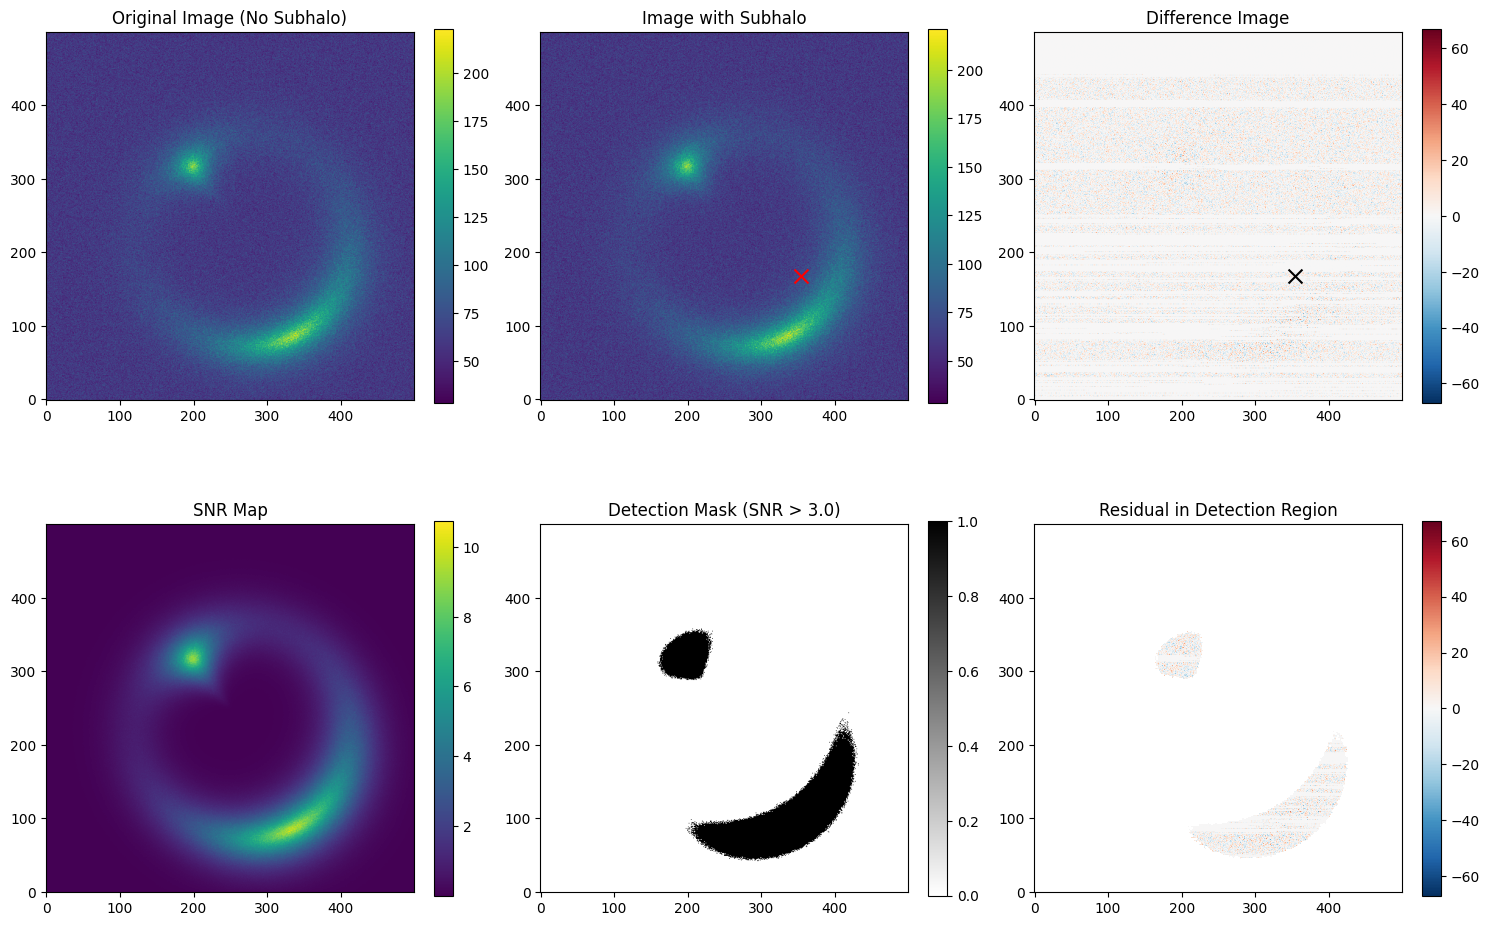


Summary Statistics:
Number of SNR regions: 236
Maximum regional SNR: 603.13
Pixels in detection mask: 18153
Total pixels: 250000
Fraction of pixels used: 0.073


In [67]:
# ========================================
# Cell 5: Visualization of Detection Results
# ========================================

# Create visualization of the detection
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Get the 5σ result for visualization
result_5sigma = results[0.00001]

# Get the 2D shape using shape_native
shape_2d = observation_data.data.shape_native

# 1. Original image (no subhalo)
ax = axes[0, 0]
im1 = ax.imshow(observation_data.data.native, origin='lower', cmap='viridis')
ax.set_title('Original Image (No Subhalo)')
plt.colorbar(im1, ax=ax, fraction=0.046)

# 2. Image with subhalo
ax = axes[0, 1]
im2 = ax.imshow(observation_with_subhalo.data.native, origin='lower', cmap='viridis')
# Convert arcsec position to pixel coordinates
pixel_x = subhalo_x / observation_data.pixel_scale + shape_2d[1]/2
pixel_y = subhalo_y / observation_data.pixel_scale + shape_2d[0]/2
ax.scatter(pixel_x, pixel_y, c='red', s=100, marker='x')
ax.set_title('Image with Subhalo')
plt.colorbar(im2, ax=ax, fraction=0.046)

# 3. Difference image
ax = axes[0, 2]
diff = observation_with_subhalo.data.native - observation_data.data.native
im3 = ax.imshow(diff, origin='lower', cmap='RdBu_r', 
                vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
ax.scatter(pixel_x, pixel_y, c='black', s=100, marker='x')
ax.set_title('Difference Image')
plt.colorbar(im3, ax=ax, fraction=0.046)

# 4. SNR map
ax = axes[1, 0]
snr_2d = detector.snr_array.reshape(shape_2d)
im4 = ax.imshow(snr_2d, origin='lower', cmap='viridis')
ax.set_title('SNR Map')
plt.colorbar(im4, ax=ax, fraction=0.046)

# 5. Detection mask
ax = axes[1, 1]
mask_2d = detector.snr_mask.reshape(shape_2d)
im5 = ax.imshow(mask_2d, origin='lower', cmap='binary')
ax.set_title(f'Detection Mask (SNR > {detector.snr_threshold})')
plt.colorbar(im5, ax=ax, fraction=0.046)

# 6. Residual in detection region
ax = axes[1, 2]
residual_2d = result_5sigma.residual.reshape(shape_2d)
masked_residual = np.ma.masked_where(~mask_2d, residual_2d)
im6 = ax.imshow(masked_residual, origin='lower', cmap='RdBu_r',
                vmin=-np.max(np.abs(residual_2d)), vmax=np.max(np.abs(residual_2d)))
ax.set_title('Residual in Detection Region')
plt.colorbar(im6, ax=ax, fraction=0.046)

plt.tight_layout()
plt.savefig(f'{output_path_prefix}/detection_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Number of SNR regions: {detector.num_regions}")
print(f"Maximum regional SNR: {detector.max_region_snr:.2f}")
print(f"Pixels in detection mask: {detector.pixels_unmasked}")
print(f"Total pixels: {observation_data.data.size}")
print(f"Fraction of pixels used: {detector.pixels_unmasked/observation_data.data.size:.3f}")

In [65]:
# ========================================
# Cell 6: Comprehensive Debugging and Physical Accuracy Verification
# ========================================

print("=" * 80)
print("COMPREHENSIVE DEBUGGING AND PHYSICAL ACCURACY VERIFICATION")
print("=" * 80)

# 1. VERIFY OBSERVATION DATA PROPERTIES
print("\n1. OBSERVATION DATA PROPERTIES")
print("-" * 40)
print(f"Exposure time: {observation_data.exposure_time} s")
print(f"Pixel scale: {observation_data.pixel_scale} arcsec/pixel")
print(f"Gain: {observation_data.gain} e-/ADU")
print(f"Read noise: {observation_data.read_noise} e-")
print(f"Image shape (2D): {observation_data.data.shape_native}")
print(f"Total pixels: {observation_data.data.size}")

# 2. VERIFY UNITS AND CONVERSIONS
print("\n2. UNITS AND CONVERSIONS VERIFICATION")
print("-" * 40)

# Check baseline observation
total_adu = np.sum(observation_data.data.native)
total_electrons = total_adu * observation_data.gain
print(f"Total counts in baseline image: {total_adu:.1f} ADU = {total_electrons:.1f} e-")

# Check source counts
source_eps_total = np.sum(observation_data.noiseless_source_eps)
source_electrons_total = source_eps_total * observation_data.exposure_time
print(f"Total source flux: {source_eps_total:.1f} e-/s = {source_electrons_total:.1f} e- total")

# Verify ground truth matches
gt_total = np.sum(source_counts_ground_truth)
print(f"Ground truth source electrons: {gt_total:.1f} e-")
print(f"Match check: {np.isclose(source_electrons_total, gt_total)}")

# 3. SNR CALCULATION VERIFICATION
print("\n3. SNR CALCULATION VERIFICATION")
print("-" * 40)

# Get a sample of SNR values
snr_flat = detector.snr_array
snr_nonzero = snr_flat[snr_flat > 0]
print(f"SNR statistics:")
print(f"  Min (non-zero): {np.min(snr_nonzero):.3f}")
print(f"  Max: {np.max(snr_flat):.3f}")
print(f"  Mean: {np.mean(snr_flat):.3f}")
print(f"  Median: {np.median(snr_flat):.3f}")
print(f"  99th percentile (threshold): {np.quantile(snr_flat, 0.99):.3f}")

# Verify SNR calculation at a bright pixel
bright_idx = np.argmax(source_counts_ground_truth.flatten())
bright_source = source_counts_ground_truth.flatten()[bright_idx]
bright_total = (observation_data.data.native.flatten()[bright_idx] * observation_data.gain)
bright_snr_calc = bright_source / np.sqrt(bright_total) if bright_total > 0 else 0
bright_snr_stored = detector.snr_array[bright_idx]
print(f"\nBright pixel verification:")
print(f"  Source counts: {bright_source:.1f} e-")
print(f"  Total counts: {bright_total:.1f} e-")
print(f"  Calculated SNR: {bright_snr_calc:.3f}")
print(f"  Stored SNR: {bright_snr_stored:.3f}")
print(f"  Match: {np.isclose(bright_snr_calc, bright_snr_stored, rtol=1e-3)}")

# 4. MASK AND REGION ANALYSIS
print("\n4. MASK AND REGION ANALYSIS")
print("-" * 40)
print(f"Total pixels: {detector.snr_array.size}")
print(f"Pixels above threshold: {detector.pixels_unmasked}")
print(f"Fraction unmasked: {detector.pixels_unmasked/detector.snr_array.size:.3f}")
print(f"Number of regions: {detector.num_regions}")
print(f"Maximum regional SNR: {detector.max_region_snr:.2f}")

# Analyze region sizes
labeled_2d = detector.labeled_regions.reshape(shape_2d)
region_sizes = []
for i in range(1, detector.num_regions + 1):
    size = np.sum(labeled_2d == i)
    region_sizes.append(size)
if region_sizes:
    print(f"Region sizes: min={min(region_sizes)}, max={max(region_sizes)}, mean={np.mean(region_sizes):.1f}")

# 5. SUBHALO IMPACT ANALYSIS
print("\n5. SUBHALO IMPACT ANALYSIS")
print("-" * 40)

# Get difference statistics
diff_adu = observation_with_subhalo.data.native - observation_data.data.native
diff_electrons = diff_adu * observation_data.gain

print(f"Subhalo parameters:")
print(f"  Mass: {lensing_with_subhalo.subhalo_mass:.1e} M_sun")
print(f"  Model: {lensing_with_subhalo.subhalo_model}")
print(f"  Position: ({subhalo_x:.3f}, {subhalo_y:.3f}) arcsec")
print(f"  Einstein radius: {lensing_with_subhalo.subhalo_einstein_radius:.6f} arcsec")

print(f"\nDifference image statistics (ADU):")
print(f"  Min: {np.min(diff_adu):.3f}")
print(f"  Max: {np.max(diff_adu):.3f}")
print(f"  Mean: {np.mean(diff_adu):.6f}")
print(f"  RMS: {np.sqrt(np.mean(diff_adu**2)):.3f}")
print(f"  Total |difference|: {np.sum(np.abs(diff_adu)):.1f}")

# Check local impact near subhalo
pixel_x = int(subhalo_x / observation_data.pixel_scale + shape_2d[1]/2)
pixel_y = int(subhalo_y / observation_data.pixel_scale + shape_2d[0]/2)
window = 5  # pixels around subhalo
y_min = max(0, pixel_y - window)
y_max = min(shape_2d[0], pixel_y + window + 1)
x_min = max(0, pixel_x - window)
x_max = min(shape_2d[1], pixel_x + window + 1)

local_diff = diff_adu[y_min:y_max, x_min:x_max]
print(f"\nLocal impact (±{window} pixels):")
print(f"  Max local |difference|: {np.max(np.abs(local_diff)):.3f} ADU")
print(f"  Mean local |difference|: {np.mean(np.abs(local_diff)):.3f} ADU")

# 6. CHI-SQUARE CALCULATION VERIFICATION
print("\n6. CHI-SQUARE CALCULATION VERIFICATION")
print("-" * 40)

# Manual chi-square calculation for verification
expected_masked = observation_data.data.native.flatten()[detector.snr_mask]
observed_masked = observation_with_subhalo.data.native.flatten()[detector.snr_mask]

# Check for zeros or negatives
num_zeros_expected = np.sum(expected_masked <= 0)
num_zeros_observed = np.sum(observed_masked <= 0)
print(f"Zeros/negatives in expected: {num_zeros_expected}")
print(f"Zeros/negatives in observed: {num_zeros_observed}")

# Calculate chi-square manually
epsilon = 1e-10
chi2_manual = np.sum((observed_masked - expected_masked)**2 / (expected_masked + epsilon))
chi2_stored = results[0.00001].chi2_value
print(f"Chi-square (manual): {chi2_manual:.2f}")
print(f"Chi-square (stored): {chi2_stored:.2f}")
print(f"Match: {np.isclose(chi2_manual, chi2_stored, rtol=1e-6)}")

# Verify degrees of freedom
dof_calc = detector.pixels_unmasked - 3
print(f"\nDegrees of freedom: {dof_calc}")
print(f"DOF calculation: {detector.pixels_unmasked} pixels - 3 parameters")

# 7. DETECTION THRESHOLD VERIFICATION
print("\n7. DETECTION THRESHOLD VERIFICATION")
print("-" * 40)

from scipy.stats import chi2 as chi2_dist
for sig_level in [0.001, 0.0001, 0.00001]:
    sigma_label = {0.001: '3σ', 0.0001: '4σ', 0.00001: '5σ'}[sig_level]
    result = results[sig_level]
    
    # Verify threshold calculation
    rv = chi2_dist(result.dof)
    threshold_calc = rv.isf(sig_level)
    
    print(f"\n{sigma_label} detection:")
    print(f"  Significance level: {sig_level}")
    print(f"  Chi² value: {result.chi2_value:.2f}")
    print(f"  Threshold (calculated): {threshold_calc:.2f}")
    print(f"  Threshold (stored): {result.threshold:.2f}")
    print(f"  Detected: {result.detected}")
    print(f"  p-value: {rv.sf(result.chi2_value):.2e}")

# 8. PHYSICAL PLAUSIBILITY CHECKS
print("\n8. PHYSICAL PLAUSIBILITY CHECKS")
print("-" * 40)

# Check noise levels
noise_region = observation_data.data.native[0:20, 0:20]  # Corner region likely background
noise_std = np.std(noise_region)
expected_noise = np.sqrt(observation_data.read_noise**2/observation_data.gain**2 + 
                        np.mean(noise_region))  # Rough approximation
print(f"Measured noise (corner region): {noise_std:.3f} ADU")
print(f"Expected noise (rough): {expected_noise:.3f} ADU")

# Check if subhalo signal is physically reasonable
subhalo_einstein_mas = lensing_with_subhalo.subhalo_einstein_radius * 1000  # milliarcsec
print(f"\nSubhalo Einstein radius: {subhalo_einstein_mas:.3f} mas")
print(f"Pixel scale: {observation_data.pixel_scale * 1000:.1f} mas/pixel")
print(f"Subhalo size in pixels: {subhalo_einstein_mas / (observation_data.pixel_scale * 1000):.2f}")

# Check total flux conservation (approximately)
total_flux_no_sub = np.sum(observation_data.data.native)
total_flux_with_sub = np.sum(observation_with_subhalo.data.native)
flux_change_percent = 100 * (total_flux_with_sub - total_flux_no_sub) / total_flux_no_sub
print(f"\nFlux conservation check:")
print(f"  Total flux without subhalo: {total_flux_no_sub:.1f} ADU")
print(f"  Total flux with subhalo: {total_flux_with_sub:.1f} ADU")
print(f"  Change: {flux_change_percent:.3f}%")

print("\n" + "=" * 80)
print("DEBUGGING COMPLETE")
print("=" * 80)

COMPREHENSIVE DEBUGGING AND PHYSICAL ACCURACY VERIFICATION

1. OBSERVATION DATA PROPERTIES
----------------------------------------
Exposure time: 60.0 s
Pixel scale: 0.00716 arcsec/pixel
Gain: 1.0 e-/ADU
Read noise: 0.2 e-
Image shape (2D): (500, 500)
Total pixels: 250000

2. UNITS AND CONVERSIONS VERIFICATION
----------------------------------------
Total counts in baseline image: 16924285.5 ADU = 16924285.5 e-
Total source flux: 31570.2 e-/s = 1894214.8 e- total
Ground truth source electrons: 1894214.8 e-
Match check: True

3. SNR CALCULATION VERIFICATION
----------------------------------------
SNR statistics:
  Min (non-zero): 0.000
  Max: 10.743
  Mean: 0.796
  Median: 0.192
  99th percentile (threshold): 6.800

Bright pixel verification:
  Source counts: 133.3 e-
  Total counts: 214.1 e-
  Calculated SNR: 9.112
  Stored SNR: 9.111
  Match: True

4. MASK AND REGION ANALYSIS
----------------------------------------
Total pixels: 250000
Pixels above threshold: 18153
Fraction unmask